# **Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

# **Data**

In [2]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [3]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


# **Exploratory Data Analysis**

In [4]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

,rating,review_length,contains_excellent,contains_terrible
0,1,920.468307,0.021760,0.096500
1,2,871.423573,0.053407,0.071823
2,3,737.867195,0.080278,0.042616
3,4,526.661922,0.149466,0.006101
4,5,431.168326,0.222345,0.002028


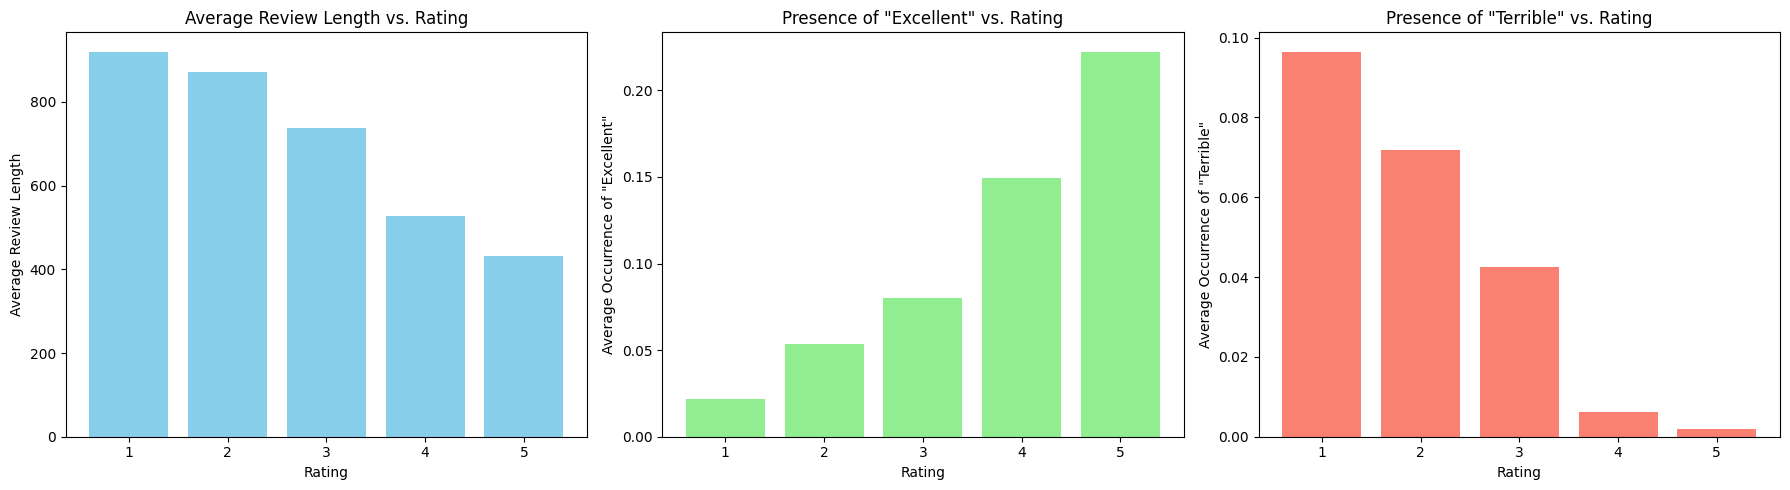

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [6]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,582,0,0,2024


In [7]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

,year,rating
0,2018,4.319710
1,2019,4.246012
2,2020,4.046103
3,2021,2.435294
4,2022,2.181159
5,2023,2.684112
6,2024,2.333333


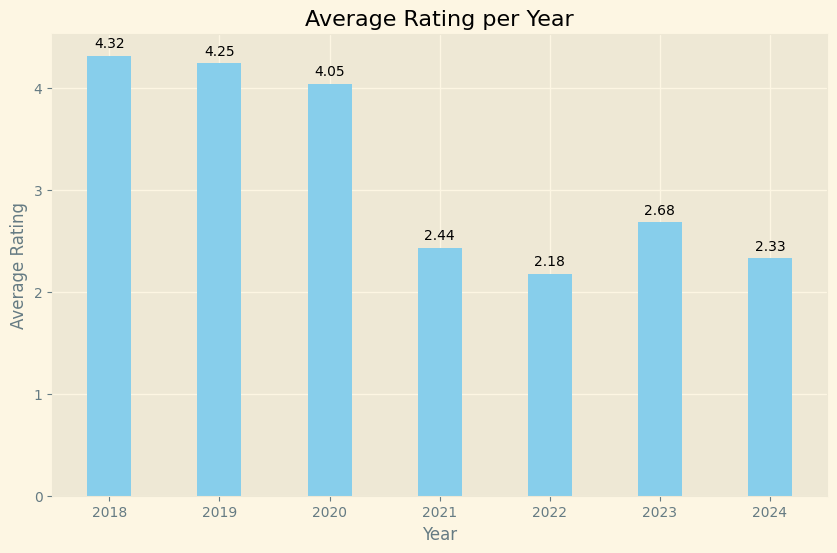

In [8]:
# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

plt.style.use('Solarize_Light2')
plt.figure(figsize=(10, 6))
bars = plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue', width=0.4)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{abs(height):.2f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Average Rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()


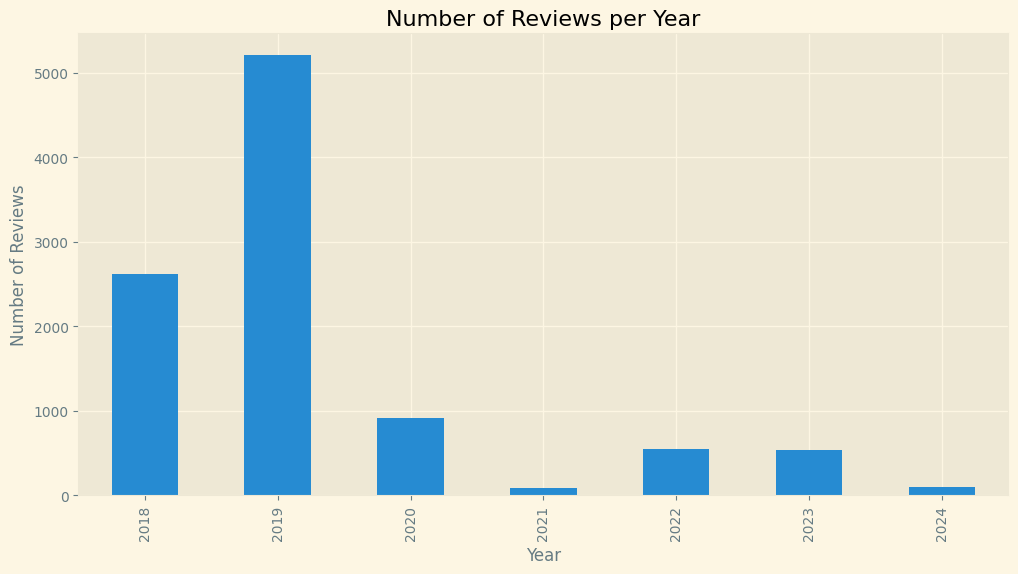

In [9]:
# Plot the number of text per year
df['year'] = df['published_date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

## The drop in the number of reviews is highly likely due to the Covid pandemic leading to the sharp decrease in the number of people traveling.

# **Prepare BERTopic model**

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Start with the default English stop words
custom_stop_words = set(stop_words)

# Add additional words that are too generic specifically in airline reviews
additional_stop_words = {"customer", "airlines", "airline", "get", "one", "never", "understand", "even", 
                         "fly", "flight", "flights", "flying", "flew", "flown", "travel", "travelling",
                         "would", "said", "us", "told", "singapore", "sq", "sa", "sia"}
custom_stop_words.update(additional_stop_words)

# Convert back to list
custom_stop_words = list(custom_stop_words)

# Select an embedding model for the text data ("all-MiniLM-L6-v2" is chosen for its balance between speed and performance)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Select a Dimensionality Reduction method
umap_model = UMAP(n_components=5, 
                  n_neighbors=8, # To help focusing on identifying local structures that would lead to more coherent topics
                  min_dist=0.3,
                  metric='cosine', 
                  random_state=42)


# Define a custom HDBSCAN model with tuned hyperparameters
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,       
    min_samples=10,            
    cluster_selection_epsilon=0.1,    
    prediction_data=True
)


# Create a custom vectorizer with the stop words and n-grams
vectorizer = CountVectorizer(stop_words=list(custom_stop_words),
                             ngram_range=(1, 2))


# Using TfidfVectorizer instead of CountVectorizer for rarer and more informative words
custom_vectorizer = TfidfVectorizer(
    stop_words=custom_stop_words,
    ngram_range=(1, 2)
)

# Using multiple representation model for better topic representation
# The main representation for summarizing topics
main_representation = KeyBERTInspired()

# An additional way of representing topics using a part-of-speech filter
pos_model = PartOfSpeech("en_core_web_sm")

# Combining two approaches for a diverse representation (KeyBERTInspired and MMR)
mmr_model = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

# Group all representation methods into a dictionary
representation_model = {
   "Main": main_representation,
   "POS": pos_model,
   "MMR": mmr_model
}

# Initialize BERTopic using the custom vectorizer
topic_model = BERTopic(embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       #vectorizer_model=vectorizer,
                       vectorizer_model=custom_vectorizer, # Using TfidfVectorizer
                       representation_model=representation_model)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/duonglai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Approach**
In order to be able identify nuances of reviews of each year, we will use the model separately on each year to identify the topics of reviews.
Running fit_transform on each year’s dataset allows each model to focus on that year’s data. This way, the latent topics will closely reflect the specific themes and sentiments unique to that period— which is important in our case where the tone and content differ significantly from positive to negative reviews.

# **2018**

## Data Slicing

In [11]:
df_2018 = df[df['year'] == 2018]
df_2018.shape

(2618, 11)

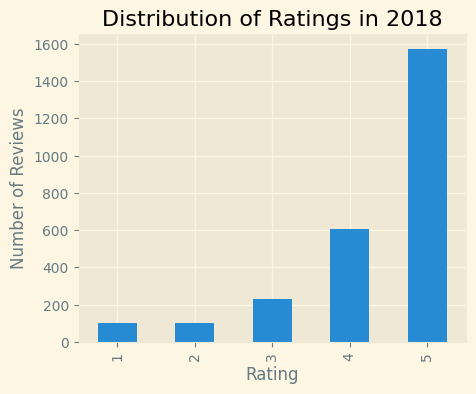

In [12]:
# Distribution of ratings in 2018
df_2018['rating'].value_counts().sort_index().plot(kind='bar', figsize=(5, 4))
plt.title('Distribution of Ratings in 2018')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic

In [13]:
topics, probs = topic_model.fit_transform(df_2018['text'])
topic_model.get_topic_info()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,1310,-1_booking_seats_passengers_seat,"[booking, seats, passengers, seat, boarding, c...","[service, food, class, good, seat, time, seats...","[booking, boarding, lounge, business class, ca...",[My access online to select my dietary prefere...
1,0,586,0_comfortable seats_seats comfortable_cabin cr...,"[comfortable seats, seats comfortable, cabin c...","[good, food, service, comfortable, staff, grea...","[seats comfortable, cabin crew, boarding, infl...",[I have used this airline a number of times an...
2,1,161,1_air canada_asia pacific_traveling_planes,"[air canada, asia pacific, traveling, planes, ...","[service, good, best, food, great, staff, time...","[air canada, cabin crew, shanghai, thai, haul,...",[As long-haul travel veterans of over 40 years...
3,2,87,2_food quality_service friendly_cabin_entertai...,"[food quality, service friendly, cabin, entert...","[service, good, food, experience, crew, great,...","[food quality, service friendly, entertainment...",[We have been loyal supporters of SQ for many ...
4,3,85,3_singaporeair_changi airport_plane good_changi,"[singaporeair, changi airport, plane good, cha...","[food, good, great, staff, movies, time, servi...","[singaporeair, changi airport, plane good, cab...",[I have reviewed my hotel separately but the w...
5,4,84,4_qantas emirates_qantas_better melbourne_sydney,"[qantas emirates, qantas, better melbourne, sy...","[brisbane, good, service, food, great, staff, ...","[qantas emirates, recommend brisbane, use melb...",[We actually flew PE from Brisbane to London a...
6,5,73,5_passengers_boarding_serving_meals,"[passengers, boarding, serving, meals, attenda...","[time, staff, meal, hours, food, delay, hour, ...","[boarding, serving, attendant, airport, snacks...",[My family of five have had good experiences w...
7,6,71,6_a380 good_a380 seat_a380 aircraft_love a380,"[a380 good, a380 seat, a380 aircraft, love a38...","[good, food, service, seats, new, seat, airbus...","[a380 seat, a380 aircraft, friendly a380, a380...",[Longhaul economy is a tough gig at the best o...
8,7,34,7_economy seating_economy premium_economy seat...,"[economy seating, economy premium, economy sea...","[economy, premium, premium economy, seats, goo...","[economy premium, economy seats, economy passe...",[We had booked economy but were offered an upg...
9,8,30,8_premium economy_economy seat_aircraft premiu...,"[premium economy, economy seat, aircraft premi...","[economy, premium, premium economy, leg, seats...","[premium economy, economy seat, aircraft premi...",[Recently flew premium economy on Singapore Ai...


In [14]:
topic_model.get_topic(0, full=True)

{'Main': [('comfortable seats', np.float32(0.550828)),
  ('seats comfortable', np.float32(0.5354465)),
  ('cabin crew', np.float32(0.47347677)),
  ('seats', np.float32(0.47203565)),
  ('cabin', np.float32(0.45106977)),
  ('service great', np.float32(0.45078248)),
  ('boarding', np.float32(0.4475733)),
  ('aircraft', np.float32(0.43733245)),
  ('inflight', np.float32(0.42843637)),
  ('service good', np.float32(0.42183906))],
 'POS': [('good', np.float64(0.018725772230942545)),
  ('food', np.float64(0.018521903660200068)),
  ('service', np.float64(0.017467770533062747)),
  ('comfortable', np.float64(0.012586803675445275)),
  ('staff', np.float64(0.012445485658475489)),
  ('great', np.float64(0.012355873278512194)),
  ('seats', np.float64(0.010009245776072144)),
  ('excellent', np.float64(0.009798508876078702)),
  ('crew', np.float64(0.009551095037416244)),
  ('friendly', np.float64(0.009484592745864698))],
 'MMR': [('seats comfortable', np.float32(0.5354465)),
  ('cabin crew', np.float32

In [15]:
topic_model.get_topic(12, full=True)

{'Main': [('seats duty', np.float32(0.47819254)),
  ('assigning seats', np.float32(0.46043864)),
  ('booking', np.float32(0.44717982)),
  ('seats', np.float32(0.42672962)),
  ('single booking', np.float32(0.4232302)),
  ('adjacent seats', np.float32(0.42095295)),
  ('seats though', np.float32(0.37602606)),
  ('seat', np.float32(0.34004915)),
  ('booked', np.float32(0.33099553)),
  ('ticket', np.float32(0.28909126))],
 'POS': [('seats', np.float64(0.019365520030276816)),
  ('adjacent seats', np.float64(0.01743395292921456)),
  ('seat', np.float64(0.014510369704401142)),
  ('adjacent', np.float64(0.01301817310891656)),
  ('call', np.float64(0.010636192344179373)),
  ('single booking', np.float64(0.009724923806220281)),
  ('husband', np.float64(0.009659885934270699)),
  ('email', np.float64(0.00952778639252905)),
  ('ticket', np.float64(0.009389201168340125)),
  ('higher price', np.float64(0.008911993822937647))],
 'MMR': [('assigning seats', np.float32(0.46043864)),
  ('single booking', 

## Adjusting approach

 From the initial topic extraction, we can understand the general subjects of the reviews.  
  
 However, determining whether these topics are commented positively or negatively—and uncovering any deeper meaning—remains challenging.  
  
 To address this, we will separate the analysis of topics in positive reviews from those in negative reviews.  
  
 We can easily distinguish positive and negative reviews by their ratings: those rated 4 or 5 are considered positive, while those rated 1 or 2 are regarded as negative. 
  
 Reviews with a rating of 3 will be excluded, as their neutrality could distort the interpretation of the extracted topics.

## Fitting BERTopic on highly rated reviews

In [16]:
df_2018_rating_4_5 = df_2018[df_2018['rating'].isin([4, 5])]
print("Total number of 2018 positive review:" , df_2018_rating_4_5.shape[0])

Total number of 2018 positive review: 2183


In [17]:
topics, probs = topic_model.fit_transform(df_2018_rating_4_5['text'])

In [18]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,362,-1_boarding_lounge_airport_cabin,"[boarding, lounge, airport, cabin, seats, chan...","[service, good, food, time, seats, economy, gr...","[boarding, lounge, seats, changi airport, cabi...",[I used Singapore Airlines this time flying fr...
1,0,1064,0_changi airport_passengers_boarding_cabin crew,"[changi airport, passengers, boarding, cabin c...","[service, good, food, time, economy, staff, cl...","[changi airport, cabin crew, plane, premium ec...",[Very efficient crew. Excellent service. Good ...
2,1,567,1_comfortable seats_seats comfortable_cabin cr...,"[comfortable seats, seats comfortable, cabin c...","[good, food, service, staff, comfortable, grea...","[seats comfortable, cabin crew, boarding, food...","[Very pleasant flight, great service from cabi..."
3,2,88,2_friendly a380_a380 great_seating plan_seating,"[friendly a380, a380 great, seating plan, seat...","[a380, good, seat, food, service, seats, comfo...","[friendly a380, seating plan, airbus a380, arm...",[The Singapore Airlines A380 flight from Singa...
4,3,82,3_food quality_cabin_bangkok_cabin crew,"[food quality, cabin, bangkok, cabin crew, lan...","[service, good, food, great, time, experience,...","[food quality, bangkok, cabin crew, lounge, lo...",[We have been loyal supporters of SQ for many ...
5,4,20,4_international culinary_destination culinary_...,"[international culinary, destination culinary,...","[service, great, economy, business, class, bes...","[destination culinary, inflight, chefs ample, ...",[Whilst I am a top tier frequent flyer with SI...


In [19]:
topic_model.get_topic(4, full=True)

{'Main': [('international culinary', np.float32(0.36980015)),
  ('destination culinary', np.float32(0.36201492)),
  ('inflight', np.float32(0.30521756)),
  ('chefs ample', np.float32(0.29716662)),
  ('culinary', np.float32(0.2791122)),
  ('business class', np.float32(0.2731637)),
  ('various international', np.float32(0.2563039)),
  ('culinary chefs', np.float32(0.25336623)),
  ('cabin', np.float32(0.24489602)),
  ('trip first', np.float32(0.2448817))],
 'POS': [('service', np.float64(0.018587669507428947)),
  ('great', np.float64(0.01803470184793814)),
  ('economy', np.float64(0.01687353912388805)),
  ('business', np.float64(0.016756080633568073)),
  ('class', np.float64(0.015379109553386425)),
  ('best', np.float64(0.014266070684388975)),
  ('chefs', np.float64(0.01366440286854477)),
  ('crew', np.float64(0.013522390922383633)),
  ('seats', np.float64(0.013162876362473758)),
  ('first', np.float64(0.012816608050609113))],
 'MMR': [('destination culinary', np.float32(0.36201492)),
  (

In [20]:
topic_model.get_representative_docs(1)

['Very pleasant flight, great service from cabin crew, food very good and choice available. Comfortable seat and leg room. Wide choice of entertainment during flight. Would wholeheartedly recommend this airline.',
 'Seats were comfortable Cabin Crew were friendly and helpful and food was good Entertainment selection of movies were good I had a good flight',
 'Service was extremely good. The staff friendly, food was good and enough for the trip. There was a good amount of leg room for an economy flight.']

## Fitting BERTopic on lowly rated reviews

In [21]:
df_2018_rating_1_2 = df_2018[df_2018['rating'].isin([1, 2])]
print("Total number of 2018 negative review:" , df_2018_rating_1_2.shape[0])

Total number of 2018 negative review: 203


In [22]:
topics, probs = topic_model.fit_transform(df_2018_rating_1_2['text'])

In [23]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,85,-1_booking_seats_passengers_adjacent seats,"[booking, seats, passengers, adjacent seats, a...","[seat, business, class, seats, service, bookin...","[booking, passengers, adjacent seats, business...",[This review is to highlight a possibly planne...
1,0,70,0_passengers_boarding_cabin crew_cabin,"[passengers, boarding, cabin crew, cabin, bagg...","[seat, service, crew, time, delay, hours, seat...","[passengers, baggage, meal, behaviour, guangzh...","[Hello there,\nMy details\nPNR:-RD48F5\nFLIGHT..."
2,1,48,1_economy seat_premium economy_economy leg_eco...,"[economy seat, premium economy, economy leg, e...","[economy, premium, seat, premium economy, clas...","[economy seat, emirates, economy lite, cathay ...",[Chose to fly Singapore Airlines because it wa...


In [24]:
topic_model.get_topic(1, full=True)

{'Main': [('economy seat', np.float32(0.43893817)),
  ('premium economy', np.float32(0.41533595)),
  ('economy leg', np.float32(0.3650755)),
  ('economy class', np.float32(0.35632327)),
  ('emirates', np.float32(0.33633807)),
  ('economy lite', np.float32(0.31330165)),
  ('economy', np.float32(0.3124339)),
  ('fare', np.float32(0.30196607)),
  ('cathay pacific', np.float32(0.29700154)),
  ('air nz', np.float32(0.28921002))],
 'POS': [('economy', np.float64(0.053164486441813236)),
  ('premium', np.float64(0.02855002607681806)),
  ('seat', np.float64(0.024757652600049772)),
  ('premium economy', np.float64(0.024653735575565102)),
  ('class', np.float64(0.02350782173263968)),
  ('service', np.float64(0.02342876830521387)),
  ('food', np.float64(0.019074719984663625)),
  ('seats', np.float64(0.018828500566352973)),
  ('leg', np.float64(0.01878165825632659)),
  ('good', np.float64(0.014480488130944125))],
 'MMR': [('economy seat', np.float32(0.43893817)),
  ('emirates', np.float32(0.3363380

In [25]:
topic_model.get_representative_docs(0)

['Hello there,\nMy details\nPNR:-RD48F5\nFLIGHT NO:-SQ851\nNAME:-VITHLANI/MAYUR\nDATE OF TRAVEL:-27-09-2018\nDESTINATION:-GUANGZHOU TO SINGAPORE\nFirst incident with Ms Manish abdul wahab(air hostess SQ851)\nI travelled today afternoon from guangzhou to singapore while your air hotess serving food i request her can you give me extra butter if you have?\nHer name is ms Manish abdul wahab\nShe replied VERY VERY RUDELY we can’t serve you as we have to serve others and started serving other passengers.\nI was like seriously is this a behaviour of singapore airline air hostess?it’s ok if you don’t wanna give but you should not treat a passenger like this.\nI was getting direct flight from delhi(india) to guangzhou(china) in (total five hours journey) but why i selected singapore airlines via singapore (total journey time approximately nineteen hours) because of your airlines name and service.\nBut very much disappointed with this type of your VERY RUDE BEHAVIOUR\nIn very lower class airline

## 2018 Summary
- We can see that positive revies are more focused on in-flight service, especially from premium economy and business class passengers. These reviews praises the airline on their food, airplane seats, inflight entertainment, cabin crew attitude and overall experience flying with the airline.
- On the other hand, negative reviews are coming from economy class and focused more on the airline's customer service, especially in terms of flight cancellations and delays. The reviews also mention the airline's baggage handling and check-in process. 
- Generally, Singapore Airline is performing well in terms of customer satisfaction. Despite there are complaints on the airline's customer service, the positive reviews outweigh the negative reviews, thus giving the airline a good rating.
- This is an indication that while the airline is doing a good job serving its customers, there are still cases where customer are mistreated and the airline should focus on improving these certain areas.

# **2019**

## Data Slicing

In [26]:
df_2019 = df[df['year'] == 2019]

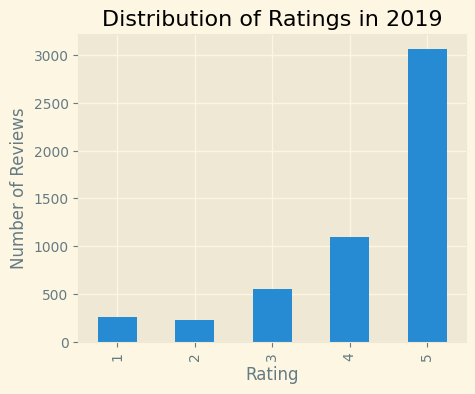

In [27]:
# Distribution of ratings in 2018
df_2019['rating'].value_counts().sort_index().plot(kind='bar', figsize=(5, 4))
plt.title('Distribution of Ratings in 2019')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic on highly rated reviews

In [28]:
df_2019_rating_4_5 = df_2019[df_2019['rating'].isin([4, 5])]
print("Total number of 2019 positive review:" , df_2019_rating_4_5.shape[0])

Total number of 2019 positive review: 4162


In [29]:
topics, probs = topic_model.fit_transform(df_2019_rating_4_5['text'])

In [30]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,0,4098,0_seats comfortable_passengers_cabin_aircraft,"[seats comfortable, passengers, cabin, aircraf...","[service, good, food, great, staff, time, seat...","[seats comfortable, airport, boarding, cabin c...",[Excellent service from all Singapore Airlines...
1,1,64,1_changi_service good_airport_service excellent,"[changi, service good, airport, service excell...","[service, good, food, time, best, crew, great,...","[changi, service good, airport, passengers, se...","[The service in SIA is excellent, the best we ..."


In [31]:
topic_model.get_topic(0, full=True)

{'Main': [('seats comfortable', np.float32(0.48590735)),
  ('passengers', np.float32(0.38692927)),
  ('cabin', np.float32(0.3771889)),
  ('aircraft', np.float32(0.36575368)),
  ('seats', np.float32(0.3651015)),
  ('airport', np.float32(0.3641257)),
  ('inflight', np.float32(0.36357415)),
  ('boarding', np.float32(0.35790864)),
  ('cabin crew', np.float32(0.35336292)),
  ('plane', np.float32(0.3507216))],
 'POS': [('service', np.float64(0.028439344214935828)),
  ('good', np.float64(0.02731016516681379)),
  ('food', np.float64(0.027137138580100795)),
  ('great', np.float64(0.01884783354627485)),
  ('staff', np.float64(0.01820687164503035)),
  ('time', np.float64(0.017556941681919923)),
  ('seats', np.float64(0.017152008971317856)),
  ('class', np.float64(0.016573280229086645)),
  ('economy', np.float64(0.01652774265128821)),
  ('crew', np.float64(0.015686291928809135))],
 'MMR': [('seats comfortable', np.float32(0.48590735)),
  ('airport', np.float32(0.3641257)),
  ('boarding', np.float3

In [32]:
topic_model.get_representative_docs(6)

## Fitting BERTopic on lowly rated reviews

In [33]:
df_2019_rating_1_2 = df_2019[df_2019['rating'].isin([1, 2])]
print("Total number of 2019 negative review:" , df_2019_rating_1_2.shape[0])

Total number of 2019 negative review: 489


In [34]:
topics, probs = topic_model.fit_transform(df_2019_rating_1_2['text'])

In [35]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,208,-1_passengers_seats_boarding_cabin,"[passengers, seats, boarding, cabin, attendant...","[food, service, seats, time, seat, business, c...","[passengers, boarding, tickets, lounge, airpor...",[I’ve always had the highest regard for SQ inf...
1,0,113,0_booking_arrival_booked_airport,"[booking, arrival, booked, airport, ticket, bu...","[hotel, time, service, luggage, ticket, delay,...","[booking, airport, business class, delay, melb...",[Flying business class and first time with Sin...
2,1,97,1_passengers_meal_meals_boarding,"[passengers, meal, meals, boarding, serve, sea...","[service, food, seats, economy, meal, plane, b...","[passengers, meals, boarding, seating, economy...",[I have just returned to Adelaide with my elde...
3,2,28,2_premium economy_economy passengers_economy a...,"[premium economy, economy passengers, economy ...","[economy, premium, premium economy, class, foo...","[economy passengers, economy virgin, economy w...",[My husband and I travel very often long dista...
4,3,23,3_passengers_sit seat_seating_room seats,"[passengers, sit seat, seating, room seats, se...","[seat, seats, back, staff, people, nice, extra...","[passengers, room seats, boarding, toilets, qu...",[I caved in and decided to give this airline a...
5,4,20,4_room inflight_seats_seat ok_seat,"[room inflight, seats, seat ok, seat, leg room...","[seat, good, food, service, halal, seats, clas...","[room inflight, seats, stewards lovely, always...",[Everything to do with check in and boarding w...


In [36]:
topic_model.get_topic(4, full=True)

{'Main': [('room inflight', np.float32(0.47543892)),
  ('seats', np.float32(0.4399663)),
  ('seat ok', np.float32(0.41643426)),
  ('seat', np.float32(0.38384154)),
  ('leg room', np.float32(0.34351823)),
  ('parts seat', np.float32(0.32979047)),
  ('stewards lovely', np.float32(0.32696646)),
  ('cramped hardest', np.float32(0.32420692)),
  ('comfortable', np.float32(0.31966606)),
  ('always a380', np.float32(0.31544128))],
 'POS': [('seat', np.float64(0.03933614137403464)),
  ('good', np.float64(0.029368558603315897)),
  ('food', np.float64(0.022820537618012064)),
  ('service', np.float64(0.017443601092425823)),
  ('halal', np.float64(0.017115216579319543)),
  ('seats', np.float64(0.014698032304174578)),
  ('class', np.float64(0.013620155931204641)),
  ('entertainment', np.float64(0.013104151296129523)),
  ('sleep', np.float64(0.012927291586315774)),
  ('business', np.float64(0.012397659199434384))],
 'MMR': [('room inflight', np.float32(0.47543892)),
  ('seats', np.float32(0.4399663))

In [37]:
topic_model.get_representative_docs(0)

['Flying business class and first time with Singapore airlines, I am not impressed, my wife an I receive a message saying our flight was delayed over 2 hours from Phuket to Singapore the problem is we have a business class flight to Melbourne  also with Singapore on the same ticket yet (1) I received no comment about what was happening to my flight to Melbourne that we would now miss (2) there was no contact number or way to ask. Our concierge spend 30 minutes trying to talk to a person about our flight we are going to miss through no fault of our own. We finally talked to a human and they said we can put you on a flight leaving in 30 minutes, we were an hour drive so impossible so we are now finally on a flight to Melbourne leaving 2 1/2 hours later which effects other matters in Melbourne. I expected much more for a business class passenger (even economy? You should have known I had a connecting flight and given me options. I wasn’t even notified of my alternatives. Very poor service

## 2019 Summary
- More compliments on the airline's in-flight service, as well as comments on the plane's seatings, cabin crew, and food.
- Pre-flight service is also mentioned in the positive reviews, showing that the airline is doing a good job in terms of customer service.
- Especially there are many positive reviews on the cabin crew's supportive attitude, even on flights with kids and children. 
- The negative reviews are still mostly from economy class passengers, but this time also contains comments about premium economy
- There's also more complaints about the food and the in-flight service that is not as good as it used to be.
- Interestingly, there are also negative reviews about the seatings in the airplane, which is a new topic that was not prominent in the previous year. 
- Overall, the airline is still performing well in terms of customer satisfaction, but there are still areas that need to be improved.

# **2020**

## Data slicing

In [38]:
df_2020 = df[(df['year'] == 2020)]
df_2020.shape

(911, 11)

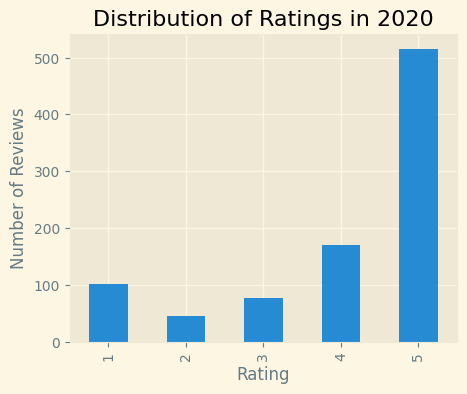

In [39]:
# Distribution of ratings in 2018
df_2020['rating'].value_counts().sort_index().plot(kind='bar', figsize=(5, 4))
plt.title('Distribution of Ratings in 2020')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic on highly rated reviews

In [40]:
df_2020_rating_4_5 = df_2020[df_2020['rating'].isin([4, 5])]
print("Total number of 2020 positive review:" , df_2020_rating_4_5.shape[0])

Total number of 2020 positive review: 686


In [41]:
topics, probs = topic_model.fit_transform(df_2020_rating_4_5['text'])

In [42]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,102,-1_class seats_class cabin_class cabins_busine...,"[class seats, class cabin, class cabins, busin...","[class, seat, passengers, seats, business, cab...","[class cabin, business class, passengers place...",[Singapore Airlines operates the A350-900 Medi...
1,0,355,0_seats_passengers_seat_boarding,"[seats, passengers, seat, boarding, cabin, air...","[service, good, food, time, great, staff, clas...","[seats, boarding, airport, cabin crew, lounge,...",[January 2020 was an incredible month as I got...
2,1,229,1_cabin crew_cabin_aircraft_boarding,"[cabin crew, cabin, aircraft, boarding, inflig...","[good, food, service, great, staff, crew, comf...","[cabin crew, boarding, inflight, food good, se...",[Great airline. Cabin crew could not be bette...


In [43]:
topic_model.get_topic(1, full=True)

{'Main': [('cabin crew', np.float32(0.4865934)),
  ('cabin', np.float32(0.46392712)),
  ('aircraft', np.float32(0.45506114)),
  ('boarding', np.float32(0.45022836)),
  ('inflight', np.float32(0.43150264)),
  ('service good', np.float32(0.41359848)),
  ('passengers', np.float32(0.41103965)),
  ('plane', np.float32(0.40960172)),
  ('good food', np.float32(0.37292036)),
  ('good service', np.float32(0.35611886))],
 'POS': [('good', np.float64(0.03906396257852478)),
  ('food', np.float64(0.035938758432233084)),
  ('service', np.float64(0.03209818630240892)),
  ('great', np.float64(0.023869423865977662)),
  ('staff', np.float64(0.022008431774255488)),
  ('crew', np.float64(0.021099302841269613)),
  ('comfortable', np.float64(0.017880231493227504)),
  ('entertainment', np.float64(0.015632607085246292)),
  ('best', np.float64(0.01545395192566692)),
  ('time', np.float64(0.01421767294943816))],
 'MMR': [('cabin crew', np.float32(0.4865934)),
  ('boarding', np.float32(0.45022836)),
  ('inflight

## Fitting BERTopic on lowly rated reviews

In [44]:
df_2020_rating_1_2 = df_2020[df_2020['rating'].isin([1, 2])]
print("Total number of 2020 negative review:" , df_2020_rating_1_2.shape[0])

Total number of 2020 negative review: 147


In [45]:
topics, probs = topic_model.fit_transform(df_2020_rating_1_2['text'])

In [46]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,68,-1_booking_refund_boarding_cancellation,"[booking, refund, boarding, cancellation, pass...","[service, staff, seat, refund, card, change, c...","[refund, boarding, cancellation, passenger, ai...",[Singapore Airlines has always been known for ...
1,0,58,0_passengers_attendant_airport_plane,"[passengers, attendant, airport, plane, seats,...","[service, hours, seat, food, back, time, seats...","[passengers, attendant, plane, seats, premium ...",[Before reading this review please note that t...
2,1,21,1_refund_refund amount_requested refund_refunded,"[refund, refund amount, requested refund, refu...","[refund, ticket, due, return, refunds, class, ...","[requested refund, cash refund, cancelled, far...",[In light of the lockdown in many countries in...


In [47]:
topic_model.get_topic(1, full=True)

{'Main': [('refund', np.float32(0.58125275)),
  ('refund amount', np.float32(0.5713319)),
  ('requested refund', np.float32(0.571038)),
  ('refunded', np.float32(0.5526857)),
  ('cash refund', np.float32(0.55214417)),
  ('refunds', np.float32(0.5517523)),
  ('full refund', np.float32(0.5249747)),
  ('cancel', np.float32(0.3373626)),
  ('return', np.float32(0.30330345)),
  ('cancelled', np.float32(0.2693101))],
 'POS': [('refund', np.float64(0.05955229565358733)),
  ('ticket', np.float64(0.01887687481697145)),
  ('due', np.float64(0.016259166083103477)),
  ('return', np.float64(0.01616410197450998)),
  ('refunds', np.float64(0.015510256873759804)),
  ('class', np.float64(0.014978410116511562)),
  ('months', np.float64(0.013143127234266189)),
  ('full', np.float64(0.012887096911140474)),
  ('tickets', np.float64(0.012302377688277162)),
  ('covid', np.float64(0.011885842396520968))],
 'MMR': [('requested refund', np.float32(0.571038)),
  ('cash refund', np.float32(0.55214417)),
  ('cancel

In [48]:
topic_model.get_representative_docs(0)

['Before reading this review please note that this was not my 1st time flying Singapore airlines and every other time was a pleasure.\nThat being said, this trip was a family holiday to Thailand and there were 12 of us on the same flight and we all agreed that this review is a must... so it\'s not just me being full of nonsense.\nWe departed from Cape Town, excited and happy that we had chosen to fly on Singapore airlines as, based on my previous experiences, I had only had good things to say... especially about the food. WELL... things have obviously changed dramatically since I last flew because the minute we got given the menus we all looked at one another in shock... the menu option even sounded gross and we all immediately started to regret not having tucked into a burger at the airport.\nWhen the food arrived it was as disgusting as it sounded on the menu. Between us we had chosen different things so it wasn\'t a case of one option being better than the other... they we both sub 

## 2020 Summary

- Interestingly, although the positive reviews still outweights the negative ones, this time food and in-flight amenities are mentioned in negative reviews
- Many negative reviews about refunds and tickets cancellation also arises, likely due to the pandemic impacting customer's schedule and travel plans.
- More importantly, there are more negative reviews about the airline's customer support's ability to handle cancellations and refunds as well as tracking customer's ticket information. 

# **2021**

## Data slicing

In [49]:
# Get 2021 data
df_2021 = df[df['year'] == 2021]
df_2021.shape

(85, 11)

This appears to be the year that the airline is impacted the most by the pandemic as indicated by the low number of reviews.

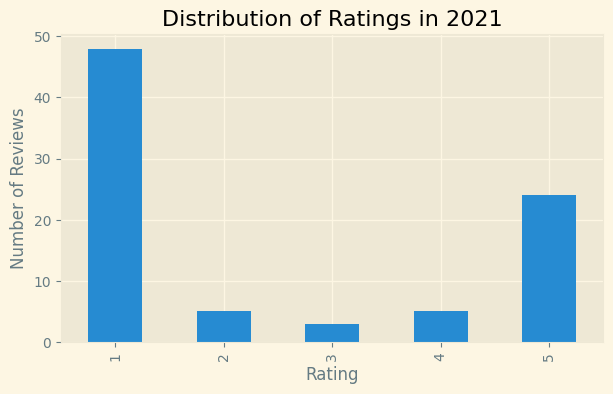

In [50]:
# Distribution of ratings in 2018
df_2021['rating'].value_counts().sort_index().plot(kind='bar', figsize=(7, 4))
plt.title('Distribution of Ratings in 2021')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic on highly rated reviews

In [51]:
df_2021_rating_4_5 = df_2021[df_2021['rating'].isin([4, 5])]
print("Total number of 2021 positive review:" , df_2021_rating_4_5.shape[0])

Total number of 2021 positive review: 29


In [52]:
topics, probs = topic_model.fit_transform(df_2021_rating_4_5['text'])

In [53]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,29,-1_changi airport_passengers_seats_drinks,"[changi airport, passengers, seats, drinks, ca...","[service, covid, good, crew, economy, time, co...","[changi airport, cabin crew, meals, a350, pand...",[Extremely unusual time to fly as we needed a...


In [54]:
topic_model.get_representative_docs(-1)

['Extremely unusual time to fly as we  needed an exemption to fly out of Australia from the government.  We obtained one as working in Tokyo for the year as teachers.  \nThe check in procedure does take a lot longer as more paperwork and phone calls are needed to check if you are allowed to travel.   The staff were excellent in explaining the procedure as they are working with very few numbers.\nThe flight had 40 people only, so lots of room and yes we had 3 seats each.  The service of meals and beverages  was done very quickly and efficiently.\nChangi airport was like a ghost town with most shops closed and all passengers are walked/transported to a transit zone until your next flight is ready.  You are then walked in single file or transported to your next flight,  so very strange as at times their seemed be more workers in PPE gear than passengers.\nThe steps we went through at Narita were extensive, downloading apps, fill in paperwork and giving a saliva sample to test for covid 19

Due to such small number of review, it is difficult to draw any conclusion from the positive reviews.

## Fitting BERTopic on lowly rated reviews

In [55]:
# Get ratings 1 and 2 from 2021 data
df_2021_low_ratings = df_2021[df_2021['rating'].isin([1, 2])]
print("Total number of 2021 negative review:" , df_2021_low_ratings.shape[0])

Total number of 2021 negative review: 53


In [56]:
topics, probs = topic_model.fit_transform(df_2021_low_ratings['text'])

In [57]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,12,-1_inflight entertainment_food offered_meal la...,"[inflight entertainment, food offered, meal la...","[meal, puppy, hours, beverage, food, upgrade, ...","[inflight entertainment, food offered, meal la...",[Flew Frankfurt to Adelaide with transit in Si...
1,0,31,0_refund_transit_ticket_need transit,"[refund, transit, ticket, need transit, fare d...","[transit, visa, change, hours, staff, wait, ai...","[refund, fare difference, booking, airport, ho...",[I booked a round-trip ticket on Singapore Air...
2,1,10,1_tried calling_service bad_callback business_...,"[tried calling, service bad, callback business...","[service, time, contact, website, hours, every...","[tried calling, service bad, callback business...",[Our ticket was puchased through an agent whic...


In [58]:
topic_model.get_topic(-1, full=True)

{'Main': [('inflight entertainment', np.float32(0.33409753)),
  ('food offered', np.float32(0.3326105)),
  ('meal landing', np.float32(0.3163199)),
  ('premium economy', np.float32(0.31127477)),
  ('inflight', np.float32(0.29382208)),
  ('offered meal', np.float32(0.2928443)),
  ('complaints', np.float32(0.2575536)),
  ('oversized baggage', np.float32(0.25153533)),
  ('meal hours', np.float32(0.24799874)),
  ('service', np.float32(0.24097374))],
 'POS': [('meal', np.float64(0.026888868919567595)),
  ('puppy', np.float64(0.020418167590978663)),
  ('hours', np.float64(0.017155051566360827)),
  ('beverage', np.float64(0.01697813481628213)),
  ('food', np.float64(0.015639804216357845)),
  ('upgrade', np.float64(0.015639804216357845)),
  ('economy', np.float64(0.015639804216357845)),
  ('service', np.float64(0.014903880421221035)),
  ('special', np.float64(0.013356353005387723)),
  ('landing', np.float64(0.013356353005387723))],
 'MMR': [('inflight entertainment', np.float32(0.33409753)),
 

In [59]:
topic_model.get_representative_docs(1)

['Our ticket was puchased through an agent which went bankrupt during Covid.  Since the last 6 months we have been trying to get our money back.  everytime we call the contact centre, after waiting 2 or 3 hours, we end up with people who cant understand simple english and just say yes to everything.  everytime they say they will callback in 2 business days but since last time 2 months have passed and nothing.  even sending a request on the website which says that someone will revert back in 2 weeks time doesnt work.  it is the worse experince ever',
 'SQ used to be one of the best airlines. Now it is frankly an embarrassment and a mess in terms of customer service. When I first bought my ticket they double charged me thousands of dollars and it took them a week to rectify the issue — nobody would pick up the phone, and I had to email, tweet at them, and call incessantly to get them to fix it (which they eventually did, admitting they made a mistake). Now their website is completely bro

## 2021 Summary
Looking at the topic keywords and the representative docs, we can see that negative reviews are largely related to the following topics:
- Customers frequently express frustration over how long it takes to process refunds or make changes to their bookings. These delays, often over seemingly simple matters, damage the airline’s reputation and create the impression of inefficiency.
- Many reviewers feel that the service quality does not justify the high ticket prices. Inadequate support and unresolved issues contribute to a growing sense that the airline is overpriced for the experience it offers.
- A critical concern raised by customers is the inability to access timely help, especially during urgent situations. Even when they manage to reach the support line, the assistance provided is often perceived as unhelpful or dismissive.
- While less commonly mentioned, some negative reviews do highlight dissatisfaction with onboard services, particularly the quality of food and in-flight amenities.

# **2022**

## Data slicing

In [60]:
df_2022 = df[df['year'] == 2022]
df_2022.shape

(552, 11)

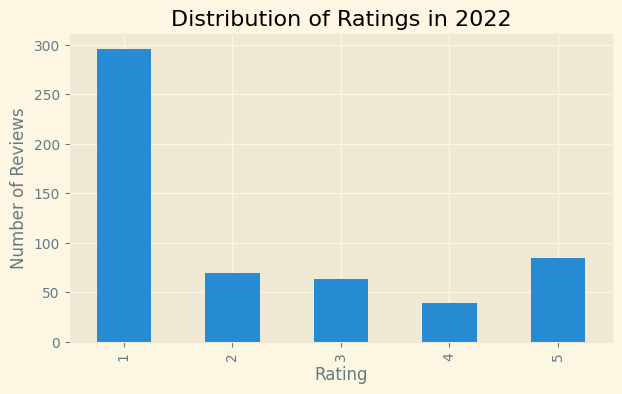

In [61]:
# Distribution of ratings in 2018
df_2022['rating'].value_counts().sort_index().plot(kind='bar', figsize=(7, 4))
plt.title('Distribution of Ratings in 2022')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic on highly rated reviews

In [62]:
df_2022_rating_4_5 = df_2022[df_2022['rating'].isin([4, 5])]
print("Total number of 2022 positive review:" , df_2022_rating_4_5.shape[0])

Total number of 2022 positive review: 124


In [63]:
topics, probs = topic_model.fit_transform(df_2022_rating_4_5['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,33,-1_class passengers_cabin crew_class seats_pas...,"[class passengers, cabin crew, class seats, pa...","[passengers, service, class, seat, business, t...","[class passengers, cabin crew, boarding, seats...",[Check-In : At the dedicated Business Class ch...
1,0,65,0_cabin crew_cabin_hospitality_seats,"[cabin crew, cabin, hospitality, seats, premiu...","[service, crew, food, good, economy, best, gre...","[cabin crew, hospitality, seats, premium econo...","[Flew Singapore Airlines from JFK to Jakarta, ..."
2,1,26,1_boarding plane_boarding_incredible cabin_pla...,"[boarding plane, boarding, incredible cabin, p...","[good, food, boarding, seat, great, class, cre...","[boarding plane, incredible cabin, seats, crew...",[Lounge : SilverKris Lounge\nVery disappointin...


In [64]:
topic_model.get_topic(1, full=True)

{'Main': [('boarding plane', np.float32(0.49575403)),
  ('boarding', np.float32(0.4525416)),
  ('incredible cabin', np.float32(0.43974277)),
  ('plane seemed', np.float32(0.4321625)),
  ('crew friendly', np.float32(0.41750714)),
  ('cabin', np.float32(0.40499973)),
  ('seats', np.float32(0.40005577)),
  ('crew seemed', np.float32(0.37884218)),
  ('boeing', np.float32(0.37360618)),
  ('clean spacious', np.float32(0.36468735))],
 'POS': [('good', np.float64(0.03407359462259997)),
  ('food', np.float64(0.025080444588778446)),
  ('boarding', np.float64(0.02343878683029902)),
  ('seat', np.float64(0.018087728301500485)),
  ('great', np.float64(0.016794474195242368)),
  ('class', np.float64(0.016271477590897143)),
  ('crew', np.float64(0.016168196594683718)),
  ('check', np.float64(0.014082264408161167)),
  ('service', np.float64(0.014005856438180298)),
  ('plane', np.float64(0.013451650682619071))],
 'MMR': [('boarding plane', np.float32(0.49575403)),
  ('incredible cabin', np.float32(0.439

## Fitting BERTopic on lowly rated reviews

In [65]:
df_2022_rating_1_2 = df_2022[df_2022['rating'].isin([1, 2])]
print("Total number of 2022 negative review:" , df_2022_rating_1_2.shape[0])

Total number of 2022 negative review: 365


In [66]:
topics, probs = topic_model.fit_transform(df_2022_rating_1_2['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,206,-1_booking_changi_melbourne_passengers,"[booking, changi, melbourne, passengers, refun...","[service, economy, time, hours, food, call, cl...","[changi, passengers, refund, airport, brisbane...",[Singapore Airlines (SIA) is terrible\nOutboun...
1,0,42,0_economy class_premium economy_passengers_seats,"[economy class, premium economy, passengers, s...","[economy, food, seat, small, seats, class, mea...","[economy class, passengers, seats, lounge, mea...",[This review covers four business class flight...
2,1,31,1_refund_return ticket_fare difference_booking,"[refund, return ticket, fare difference, booki...","[change, ticket, booking, return, email, fare,...","[refund, return ticket, fare difference, booki...",[post- Covid19 left Singapore Airlines with ve...
3,2,28,2_requested refund_refund ticket_waiting refun...,"[requested refund, refund ticket, waiting refu...","[refund, department, call, email, booking, pho...","[requested refund, refund ticket, rebook ticke...",[I have been trying to rebook a flight which w...
4,3,27,3_luggage lost_lost baggage_lost luggage_singa...,"[luggage lost, lost baggage, lost luggage, sin...","[luggage, baggage, lost, service, bag, parents...","[luggage lost, singaporeair, baggage, sin lax,...",[I flew business class on the SQ23 from NYC to...
5,4,19,4_trips service_booking_annoyed booked_sending...,"[trips service, booking, annoyed booked, sendi...","[phone, time, service, emails, hours, name, al...","[trips service, booking, refund, ticket clear,...",[Purchased business class LAX- Singaore - they...
6,5,12,5_boarding_connecting passengers_passengers_de...,"[boarding, connecting passengers, passengers, ...","[hours, service, singapor, air, delayed, great...","[boarding, connecting passengers, airport, 18 ...",[I was excited to try Singapore airlines for t...


In [67]:
topic_model.get_topic(5, full=True)

{'Main': [('boarding', np.float32(0.32352397)),
  ('connecting passengers', np.float32(0.31455958)),
  ('passengers', np.float32(0.31216693)),
  ('delayed', np.float32(0.30192202)),
  ('airport', np.float32(0.28290826)),
  ('air hostess', np.float32(0.28136918)),
  ('18 hours', np.float32(0.26763615)),
  ('plane', np.float32(0.26636878)),
  ('lost time', np.float32(0.24842851)),
  ('changi', np.float32(0.24656533))],
 'POS': [('hours', np.float64(0.017804310925873992)),
  ('service', np.float64(0.017287518279628745)),
  ('singapor', np.float64(0.01614890931993687)),
  ('air', np.float64(0.015772671843293395)),
  ('delayed', np.float64(0.014004305119426574)),
  ('great', np.float64(0.012843182408300348)),
  ('connection', np.float64(0.0117196378959328)),
  ('time', np.float64(0.011647388845064286)),
  ('virgin', np.float64(0.011486198081964907)),
  ('food', np.float64(0.01123210760218619))],
 'MMR': [('boarding', np.float32(0.32352397)),
  ('connecting passengers', np.float32(0.31455958

In [68]:
topic_model.get_representative_docs(5)

['I was excited to try Singapore airlines for the first time to see the service and hype it boasts about. Unfortunately, the service was average. First flight punctuality was horrendous they had delayed departure for almost 45 minutes the cabin crew and ground staff decided to show exception to a passenger who boarded the flight late where as did not show exception to connecting flight passengers who had to reach on time to connect the flight towards their destination. Despite the assurance provided by staff that they would ask ground staff to delay the connecting flights so we could board they did not amid so we were rebooked. Therefore, connecting flight passengers were stranded at Singapore airport missing their connection flight the lounge provided was average nothing great no reclining seats to sleep it was straight on L shaped sofas also some staff were rude. Seems like we were deliberately delayed to miss the flight and had to wait for more than 10 hours. Therefore, 19 hours jou

## 2022 Summary
The issues identified in 2021 have not only persisted into 2022 but appear to have worsened in several key areas:
- A notable shift in 2022 is the increase in complaints from premium and business class passengers. This signals a deeper problem with the quality of in-flight service, particularly the professionalism and attentiveness of the cabin crew.
- Ticketing-related problems—such as booking errors, refund delays, and difficulties in making changes—have become more frequent and severe. This growing volume of complaints raises concerns about the airline’s operational efficiency and customer service infrastructure.
- Delays and last-minute cancellations remain a major pain point for customers, contributing to a negative travel experience and further eroding trust in the airline.
- Both pre-departure and in-flight customer service are showing signs of deterioration. Reviews increasingly mention poor responsiveness and delays in basic onboard services such as food and beverages, further impacting customer satisfaction.

# **2023**

## Data slicing

In [69]:
df_2023 = df[df['year'] == 2023]
df_2023.shape

(535, 11)

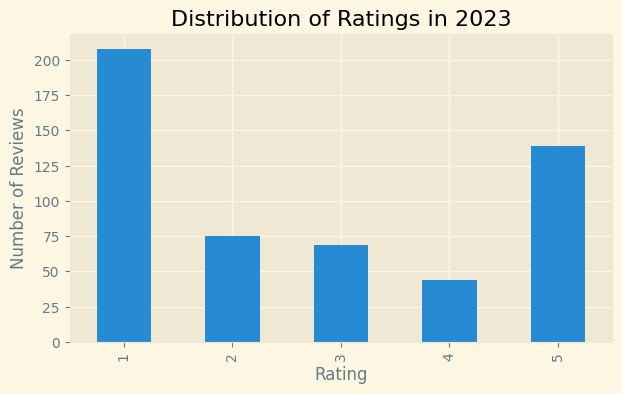

In [70]:
# Distribution of ratings in 2018
df_2023['rating'].value_counts().sort_index().plot(kind='bar', figsize=(7, 4))
plt.title('Distribution of Ratings in 2023')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Fitting BERTopic on highly rated reviews

In [71]:
df_2023_rating_4_5 = df_2023[df_2023['rating'].isin([4, 5])]
print("Total number of 2023 positive review:" , df_2023_rating_4_5.shape[0])

Total number of 2023 positive review: 183


In [72]:
topics, probs = topic_model.fit_transform(df_2023_rating_4_5['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,69,-1_passengers_baggage_class seats_cabin,"[passengers, baggage, class seats, cabin, lugg...","[class, economy, seat, passengers, seats, busi...","[passengers, baggage, class seats, cabin, busi...",[We flew on Singapore Airlines B787-10 for thi...
1,0,61,0_boarding_cabin_cabin crew_airport,"[boarding, cabin, cabin crew, airport, plane, ...","[service, food, experience, good, great, time,...","[boarding, cabin crew, airport, changi, travel...",[We recently flew coach on Singapore Airlines ...
2,1,53,1_boarding_seats_cabin_inflight,"[boarding, seats, cabin, inflight, meal, meals...","[seat, service, good, food, great, staff, crew...","[boarding, seats, cabin, meals, aircraft, a350...",[After a pleasant stay at the Silver Kris loun...


In [73]:
topic_model.get_topic(1, full=True)

{'Main': [('boarding', np.float32(0.41062257)),
  ('seats', np.float32(0.3631532)),
  ('cabin', np.float32(0.35801998)),
  ('inflight', np.float32(0.3371767)),
  ('meal', np.float32(0.33014247)),
  ('meals', np.float32(0.3153733)),
  ('aircraft', np.float32(0.3061269)),
  ('seat', np.float32(0.30603677)),
  ('plane', np.float32(0.29172614)),
  ('crew', np.float32(0.282412))],
 'POS': [('seat', np.float64(0.028251438905596282)),
  ('service', np.float64(0.024673020146673972)),
  ('good', np.float64(0.02357332757203222)),
  ('food', np.float64(0.020673111719708336)),
  ('great', np.float64(0.02049400446749534)),
  ('staff', np.float64(0.020206422375572068)),
  ('crew', np.float64(0.01994203903273847)),
  ('excellent', np.float64(0.017108504706065376)),
  ('seats', np.float64(0.015464088448163585)),
  ('time', np.float64(0.014880500092704169))],
 'MMR': [('boarding', np.float32(0.41062257)),
  ('seats', np.float32(0.3631532)),
  ('cabin', np.float32(0.35801998)),
  ('meals', np.float32(0.

## Fitting BERTopic on lowly rated reviews

In [74]:
df_2023_rating_1_2 = df_2023[df_2023['rating'].isin([1, 2])]
print("Total number of 2023 negative review:" , df_2023_rating_1_2.shape[0])

Total number of 2023 negative review: 283


In [75]:
topics, probs = topic_model.fit_transform(df_2023_rating_1_2['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,85,-1_booking_passengers_boarding_ticket,"[booking, passengers, boarding, ticket, fare, ...","[seats, service, staff, class, seat, business,...","[booking, passengers, fare, changi, airport, i...",[I have used SQ and Changi often and generally...
1,0,96,0_passengers_seats_inflight_cabin crew,"[passengers, seats, inflight, cabin crew, cabi...","[economy, crew, food, service, meal, premium, ...","[passengers, seats, airport, attendants, meal ...",[Travelled with Singapore on their premium eco...
2,1,75,1_cancellation_refund_cancel_booking,"[cancellation, refund, cancel, booking, cancel...","[service, refund, hours, ticket, class, hour, ...","[cancellation, refund, booking, layover, 5pm, ...",[I have been a loyal customer and frequent fly...
3,2,27,2_lost luggage_luggage missing_luggage found_d...,"[lost luggage, luggage missing, luggage found,...","[luggage, bag, lost, call, day, bags, service,...","[lost luggage, deliver luggage, bags, delta, i...",[Me and my family travelled from Perth to Toky...


In [76]:
topic_model.get_topic(2, full=True)

{'Main': [('lost luggage', np.float32(0.6144964)),
  ('luggage missing', np.float32(0.5801731)),
  ('luggage found', np.float32(0.570658)),
  ('deliver luggage', np.float32(0.5208669)),
  ('luggage back', np.float32(0.5176441)),
  ('luggage', np.float32(0.49004596)),
  ('luggage next', np.float32(0.4849706)),
  ('baggage', np.float32(0.47399655)),
  ('lost bag', np.float32(0.46000248)),
  ('inside luggage', np.float32(0.425406))],
 'POS': [('luggage', np.float64(0.05080882633342233)),
  ('bag', np.float64(0.02073263089011934)),
  ('lost', np.float64(0.018924249284331056)),
  ('call', np.float64(0.018923924261472266)),
  ('day', np.float64(0.017005007302543087)),
  ('bags', np.float64(0.014468150776762402)),
  ('service', np.float64(0.01390929942327385)),
  ('days', np.float64(0.013876273680371701)),
  ('next', np.float64(0.013868628343680656)),
  ('clothes', np.float64(0.013605401463452484))],
 'MMR': [('lost luggage', np.float32(0.6144964)),
  ('deliver luggage', np.float32(0.5208669)

In [77]:
topic_model.get_representative_docs(2)

['Me and my family travelled from Perth to Tokyo on January for 3 weeks holiday . First of all flight delayed for a hour because of the stupid reason that engineer had called in sick . When reaching Tokyo exhausted because of the chasing next flight at Singapore , my luggage was left behind at Singapore. Thankfully Japanese luggage handling team deals very professionally and deliver my luggage next day. \nOn the way back to Perth , we told the lady at Singapore airlines check in time that please make sure our luggage will be arrive at time . She even added the priority tag . Flight was ok to Singapore . Flight attendants were looks very rush for everything and a very slow service . After that we arrive at Singapore and went to catch the next flight . Again the flight was delayed , flight attendants were agin rushed for everything and service was way too slow . And not forget to mentioned but the planes from both Perth to Tokyo and Tokyo to Perth was quite dirty and dusty. We can see th

## 2023 Sumamry
The traditionally strong reputation of Singapore Airlines has noticeably declined, with previously positive aspects now becoming major sources of dissatisfaction across the entire customer journey—from pre-departure to arrival:
- Once a highlight of the premium offering, the airport lounge experience has deteriorated significantly, with reports of overcrowding, long queues, and a lack of available food or refreshments.
- The in-flight experience, previously a key strength, is now a frequent source of complaints. Passengers describe small, uncomfortable, and sometimes unclean seats, along with poorly prepared meals and substandard food quality.
- Reviews suggest that the cabin crew lacks coordination and appears underprepared for standard service routines, raising concerns about training and overall service management on board.
- Ticketing, refunds, and cancellations continue to frustrate customers, but a growing concern is the failure of the rewards and loyalty programs. This is particularly damaging, as it risks alienating even the airline’s most loyal customer base.
- Lost luggage complaints are rising, and the core issue appears to be the airline's poor handling of these cases through its customer support channels.
- Customer service is frequently described as not only unhelpful but also rude and unprofessional, reinforcing the perception that the airline no longer prioritizes service excellence.

# **2024**

## Data slicing

In [78]:
df_2024 = df[df['year'] == 2024]
print(df_2024.shape)

(96, 11)


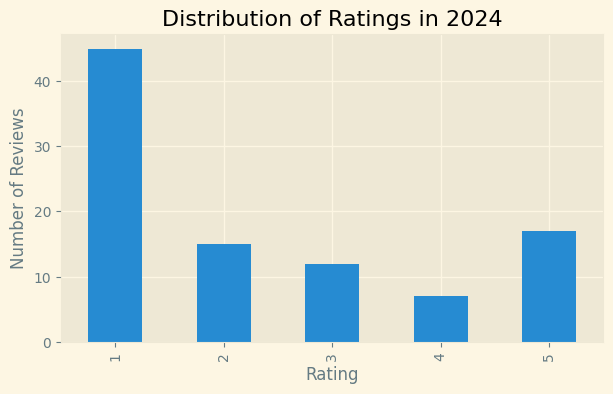

In [79]:
# Distribution of ratings in 2018
df_2024['rating'].value_counts().sort_index().plot(kind='bar', figsize=(7, 4))
plt.title('Distribution of Ratings in 2024')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

Due to the extremly small number of positive reviews, we will focus on the negative reviews for 2024 only. 

## Fitting BERTopic on lowly rated reviews

In [80]:
df_2024_rating_1_2 = df_2024[df_2024['rating'].isin([1, 2])]
print("Total number of 2024 negative review:" , df_2024_rating_1_2.shape[0])

Total number of 2024 negative review: 60


In [81]:
topics, probs = topic_model.fit_transform(df_2024_rating_1_2['text'])
topic_model.get_topic_info()

,Topic,Count,Name,Representation,POS,MMR,Representative_Docs
0,-1,25,-1_missing luggage_refund_drinks offered_baggage,"[missing luggage, refund, drinks offered, bagg...","[service, luggage, food, airport, claim, econo...","[missing luggage, refund, drinks offered, airp...",[Singapore Airlines feedback channel is one of...
1,0,24,0_passengers_cabin_seats_plane,"[passengers, cabin, seats, plane, boarded, sea...","[seat, time, service, class, cabin, chicken, e...","[passengers, cabin, star alliance, meals, prem...",[This journey I took recently with Singapore a...
2,1,11,1_bought ticket_called booking_cancel_cancelling,"[bought ticket, called booking, cancel, cancel...","[ticket, voucher, booking, company, money, bac...","[bought ticket, called booking, cancelling, mo...",[I booked a round ticket from singapore airlin...


In [82]:
topic_model.get_topic(1, full=True)

{'Main': [('bought ticket', np.float32(0.4241184)),
  ('called booking', np.float32(0.3757091)),
  ('cancel', np.float32(0.37020043)),
  ('cancelling', np.float32(0.3630726)),
  ('booking', np.float32(0.33754572)),
  ('ticket', np.float32(0.3277098)),
  ('money back', np.float32(0.32585767)),
  ('got ticket', np.float32(0.30439228)),
  ('booking com', np.float32(0.2844854)),
  ('tickets', np.float32(0.26148883))],
 'POS': [('ticket', np.float64(0.034642530053735056)),
  ('voucher', np.float64(0.033834111795040776)),
  ('booking', np.float64(0.02607654165220317)),
  ('company', np.float64(0.02225451573284126)),
  ('money', np.float64(0.019183320669633977)),
  ('back', np.float64(0.01829459985788338)),
  ('issue', np.float64(0.016809871948587844)),
  ('call', np.float64(0.015398646696356572)),
  ('service', np.float64(0.01532602485778806)),
  ('tickets', np.float64(0.015209753141277175))],
 'MMR': [('bought ticket', np.float32(0.4241184)),
  ('called booking', np.float32(0.3757091)),
  (

In [83]:
topic_model.get_representative_docs(0)

['This journey I took recently with Singapore airlines was one of the worst in my 12 years of international travel experience. I boarded in Coimbatore, India via Scoot airlines( operated by Singapore airlines). The flight was delayed by 2 hrs. They kept saying delayed by 30 mins and kept moving the time. There was no reason given. Food was not that great too. Staffs were mostly friendly except one. There was no ice cream with kids meal and it came only with adult. She gave my husband and me, we asked one more for our 9 year old daughter and she refused saying it was not part of the kids meal. Anyways, even though flight was delayed, i was hoping they would make arrangements with out flight to Seattle. However, they just made us run, literally... We were at the terminal finally and their systems did not recognize the boarding pass we had and they made us wait further for validating us manually. It was 12 hrs flight to Seattle. Seats were so close and narrow like a bus seat. Not comforta

## 2024 Summary
The same core issues continue to affect customer satisfaction, with little to no sign of improvement:
- Both pre-departure and in-flight service remain problematic, with ongoing reports of rude, unhelpful staff and a general lack of responsiveness to customer needs.
- Complaints about uncomfortable seating and poor food quality persist, indicating that the airline has yet to address key elements of the onboard experience.
- Customers continue to face long wait times and inefficient support when dealing with ticket changes or cancellations, making these processes unnecessarily frustrating.
- The noticeable drop in review volume and increased cancellations review suggests that more customers are choosing to cancel their flights or avoid flying with the airline altogether, pointing to a potential erosion of trust and loyalty.

# **Summary**
**Customer Satisfaction and Service Quality Review**
  
**2018–2020: Period of High Customer Satisfaction**  
Between 2018 and 2020, the airline enjoyed a strong reputation for customer satisfaction. Positive reviews far outweighed negative ones, with frequent praise focused on in-flight services and amenities. Key highlights included:
- Comfortable and clean seating
- High-quality food, including the popular Book the Cook program
- Friendly, professional, and well-trained cabin crews
  
While some negative reviews existed, they were minor and scattered, leaving the airline with a high overall rating and growing customer loyalty.

**2021–Present: Rapid Decline in Service Quality**  
From 2021 onwards, the airline began experiencing a significant and continuous drop in service quality and customer satisfaction. The very elements that once drove positive reviews became sources of widespread complaints:
- *Seats*: Reported as uncomfortable and dirty, even in premium and business class.
- *Food*: Declining quality in meals and poor execution of the Book the Cook service, often leaving passengers hungry and disappointed.
- *Cabin Crew*: Described as undertrained, unprepared, and frequently rude or unprofessional.
- *Luggage Handling*: An increase in lost baggage incidents, with poor support for affected customers.
- *Customer Support*: Widely criticized for being unhelpful, slow, and even making situations worse for passengers.
- *Ticketing, Cancellations & Refunds*: Numerous reports of customers being unable to get refunds or modify bookings.
- *Pricing Concerns*: With declining service levels, many customers now view the airline as overpriced and no longer worth the cost.
  
This erosion of quality has resulted in the airline losing even its most loyal customers, and if unaddressed, could lead to severe long-term consequences for the brand.


**Key Insight**
  
The most damaging aspect of this decline is not just the drop in service quality—but the perception that customers are not being listened to. Many feel unappreciated and undervalued, which fuels frustration and drives them away.


# **Recommendations**
  
**1. Fix the Fundamentals First**
  
These are the areas where the airline once excelled—and now face the most complaints. Restoring them should be the top priority to gain customer's trust and favor:
- *Seats*: Deep clean and refurbish airpcraft interiors, especially premium and business class cabin. Establish strict preflight procedures and high cleaning standards. 
- *Food & Book the Cook Service*: Re-evaluate partnerships with catering providers and re-train cabin crew on accurate order management and service timing. Make sure service standard is consistent across all flights.
- *Cabin Crew*: Launch new rigorous mandatory training programs focused on improving service exellence and professionalism. Implement a system for monitoring and rewarding good service.

**2. Repair Operational Problems**
- *Ticketing, Cancellations & Refunds*: Revise partnership with third-party ticketing platforms and other airlines to ensure ticket information are aligned across all partners. Revamp Singapore Airline's website and encourage customers to use the website other than third party platforms by promotion programs. Ensure customers problems are address in a timely manner.
- *Customer Support*: Reduce response time and increase the size of customer support teams to make sure customers' problem are addressed and look after. Devise a training program for all agents to ensure they are well-versed in the airline's policies and procedures. Implement a system for monitoring and rewarding good service as well as punishment for unprofessional behavior.
- *Baggage Handling*: Partner with ground service providers to implement better tracking systems. Implement and introduce digital baggage tracking via app notifications. Improve compensation and support protocols for lost luggage incidents.

**3. Rebuild Customer Trust** 
- *Show customers that they are heard*: Send personal apologies or compensation for recent service failures. Create a “Customer Advisory Panel”/"Customer Feedback Box" to get feedback directly from customers, which would not only help the airline to understand customers' needs but also show that the airline is willing to listen and improve.
- *Transparent Communication*: Use newsletters, in-flight videos, and social media to keep passengers informed and engaged.Communicate openly about what is being done to improve.
- *Value Proposition Readjustment*: Avoid premium pricing until service quality improves, actively offer promotions or complimentary bonuses to retain customers. 